In [1]:
# %load C:\Users\walter\Desktop\tools\plot_template.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('figure', titlesize=18)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import glob
import os

In [3]:
ami_path = 'data\\ami_time_domain\\'
model_path = 'data\\model_time_domain\\'

In [4]:
def read_data(data_type, building_type, csv_file):
    '''
    data_type: 'ami' or 'model'
    building_type: 'medium_office', 'outpatient'
    csv_file: 'cluster_centers', 'cluster_result', 'statistics'    
    '''
    path_fun = lambda data_type:'data/{}_time_domain/{}-{}'.format(data_type, data_type, building_type)
    data = pd.read_csv(path_fun(data_type)+'/{}.csv'.format(csv_file), index_col=0)
    return data

## Building type

In [5]:
ami_allFiles = glob.glob(ami_path+"/**/statistics.csv")
ami_metadata = {}
for filename in ami_allFiles:
    buildingType = filename.split('-')[1].split('\\')[0]
    data = pd.read_csv(filename)
    count = data.building_ID.nunique()
    ami_metadata[buildingType] = count

In [6]:
model_allFiles = glob.glob(model_path+"/**/statistics.csv")
model_metadata = {}
for filename in model_allFiles:
    buildingType = filename.split('-')[1].split('\\')[0]
    data = pd.read_csv(filename)
    count = data.building_ID.nunique()
    model_metadata[buildingType] = count

In [7]:
ami_metadata_df = pd.DataFrame(ami_metadata, index=['ami']).T
model_metadata_df = pd.DataFrame(model_metadata, index=['model']).T
building_count = pd.concat([ami_metadata_df, model_metadata_df], axis=1, sort=False)
building_count['compared'] = building_count.min(axis=1, skipna=False)>10

In [8]:
building_count

,ami,model,compared
full_service_restaurant,72.0,122.0,True
large_hotel,8.0,30.0,False
large_office,4.0,NaN,False
medium_office,27.0,87.0,True
outpatient,96.0,51.0,True
primary_school,21.0,51.0,True
quick_service_restaurant,29.0,37.0,True
retail,181.0,431.0,True
small_hotel,7.0,43.0,False
small_office,367.0,913.0,True


In [9]:
buildingTypes = building_count.index[building_count['compared']]

In [10]:
len(buildingTypes)

9

## cluster center
Three metrics were used to calculate the distance between cluster centers:
- Euclidean Distance
- Pearson’s Correlation
- Spearman’s Correlation (monotonic relationship)

In [11]:
from scipy.stats import spearmanr, pearsonr
from sklearn.feature_selection import mutual_info_regression

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

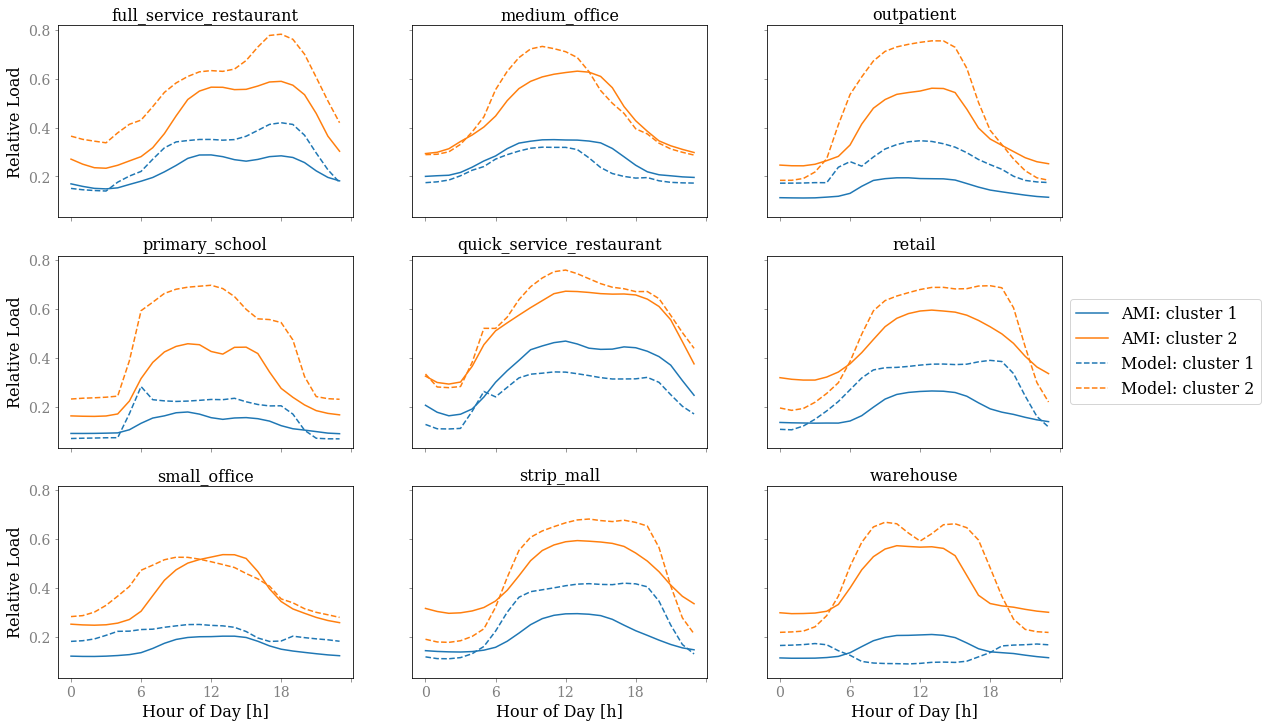

In [12]:
fig, axes = plt.subplots(len(buildingTypes)//3, 3, figsize=(18, 12),
                         sharex=True, sharey=True)
distance = {}
pcorr = {}
scorr = {}
mi = {}

i=-1
for building_type in buildingTypes:
    ami_cluster_center = read_data('ami', building_type, 'cluster_centers').T
    model_cluster_center = read_data('model', building_type, 'cluster_centers').T
    dist_c0 = np.linalg.norm(model_cluster_center[0].values-ami_cluster_center[0].values)
    dist_c1 = np.linalg.norm(model_cluster_center[1].values-ami_cluster_center[1].values)
    pcorr_c0, _ = pearsonr(model_cluster_center[0].values, ami_cluster_center[0].values)
    pcorr_c1, _ = pearsonr(model_cluster_center[1].values, ami_cluster_center[1].values)
    scorr_c0, _ = spearmanr(model_cluster_center[0].values, ami_cluster_center[0].values)
    scorr_c1, _ = spearmanr(model_cluster_center[1].values, ami_cluster_center[1].values)
    mi_c0 = mutual_info_regression(model_cluster_center[0].values.reshape(-1, 1), 
                                   ami_cluster_center[0].values.reshape(-1, 1), discrete_features=False)[0]
    mi_c1 = mutual_info_regression(model_cluster_center[1].values.reshape(-1, 1),
                                   ami_cluster_center[1].values.reshape(-1, 1), discrete_features=False)[0]
    
    distance[building_type] = [dist_c0, dist_c1]
    pcorr[building_type] = [pcorr_c0, pcorr_c1]
    scorr[building_type] = [scorr_c0, scorr_c1]
    mi[building_type] = [mi_c0, mi_c1]
    
    # plot
    i += 1
    i_row = i//3
    i_col = i%3
    axes[i_row, i_col].plot(ami_cluster_center.index, ami_cluster_center[0], 
            label='AMI: cluster 1', color=default_colors[0], ls='-')
    axes[i_row, i_col].plot(ami_cluster_center.index, ami_cluster_center[1], 
            label='AMI: cluster 2', color=default_colors[1], ls='-')
    axes[i_row, i_col].plot(model_cluster_center.index, model_cluster_center[0], 
            label='Model: cluster 1', color=default_colors[0], ls='--')
    axes[i_row, i_col].plot(model_cluster_center.index, model_cluster_center[1], 
            label='Model: cluster 2', color=default_colors[1], ls='--')
    axes[i_row, i_col].set_title(building_type, fontsize=16)
    
for i_row in range(3):    
    axes[i_row, 0].set_ylabel('Relative Load')
    
for i_col in range(3):    
    axes[2, i_col].set_xlabel('Hour of Day [h]')
    axes[2, i_col].set_xticks(np.arange(0, 25, 6))

axes[1,2].legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(os.path.join('fig','validation','byCluster','cluster_center'))

In [13]:
clusters = ['cluster_0', 'cluster_1']

distance_df = pd.DataFrame(distance, index=clusters).T
pcorr_df = pd.DataFrame(pcorr, index=clusters).T
scorr_df = pd.DataFrame(scorr, index=clusters).T
mi_df = pd.DataFrame(mi, index=clusters).T

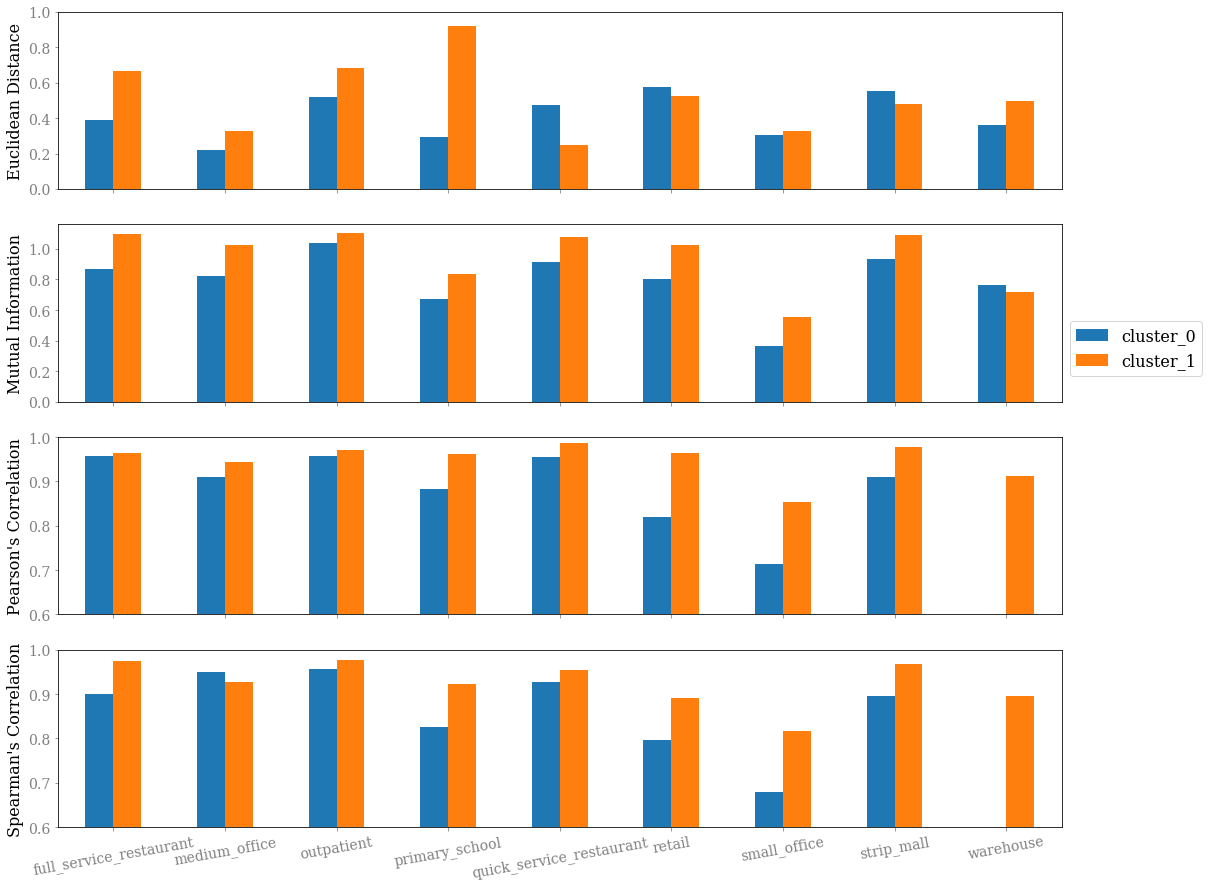

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(18, 15), sharex=True)
distance_df.plot.bar(ax=axes[0], legend=False)
mi_df.plot.bar(ax=axes[1], legend=False)
pcorr_df.plot.bar(ax=axes[2], legend=False)
scorr_df.plot.bar(ax=axes[3], legend=False)


axes[0].set_ylim([0,1])
axes[2].set_ylim([0.6,1])
axes[3].set_ylim([0.6,1])

axes[2].legend(loc='center left', bbox_to_anchor=(1,1.5))

axes[0].set_ylabel("Euclidean Distance")
axes[1].set_ylabel("Mutual Information")
axes[2].set_ylabel("Pearson's Correlation")
axes[3].set_ylabel("Spearman's Correlation")

axes[3].tick_params(axis='x', rotation=10)
plt.savefig(os.path.join('fig','validation','byCluster','cluster_center_dist'))

## distribution of key statistics

In [15]:
def cal_dist(p, q, bins, smooth = 0.001):
    p_hist, _ = np.histogram(p, bins)
    p_hist = p_hist+smooth  # avoid zero-entry for the calculation of KL-Divergence
    p_pMass = p_hist/np.sum(p_hist)
    q_hist, _ = np.histogram(q, bins)
    q_hist = q_hist+smooth  # avoid zero-entry for the calculation of KL-Divergence
    q_pMass = q_hist/np.sum(q_hist)
    kl = sum(p_pMass[i] * np.log2(p_pMass[i]/q_pMass[i]) for i in range(len(p_pMass)))    
    corr, _ = pearsonr(p_pMass, q_pMass)
    mi = mutual_info_regression(p_pMass.reshape(-1, 1), 
                                q_pMass.reshape(-1, 1), discrete_features=False)[0]        
    return kl, corr, mi

In [16]:
## each column is a metric
bins_all = {'highLoad': [np.linspace(0, 1, 50), False],
            'highLoad_SD': [np.linspace(0, 2, 50), False],
            'baseLoad': [np.linspace(0, 1, 50), False],
            'baseLoad_SD': [np.linspace(0, 2, 50), False],
            'Morning Rise Start': [np.linspace(-1, 97, 49), True],
            'High Load Start': [np.linspace(-1, 97, 49), True],
            'High Load Finish': [np.linspace(-1, 97, 49), True],
            'Afternoon Fall Finish': [np.linspace(-1, 97, 49), True],
           }

column_index = {}
for i_col, metric in zip(range(len(bins_all.keys())), bins_all.keys()):
    column_index[i_col] = metric

In [17]:
## xticks for time-related metrics
xticks_x = np.arange(0, 97, 24)
xticks_label = ["0", "6", "12", "18", "24"]

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\walter\Anaconda3\envs\EULP\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

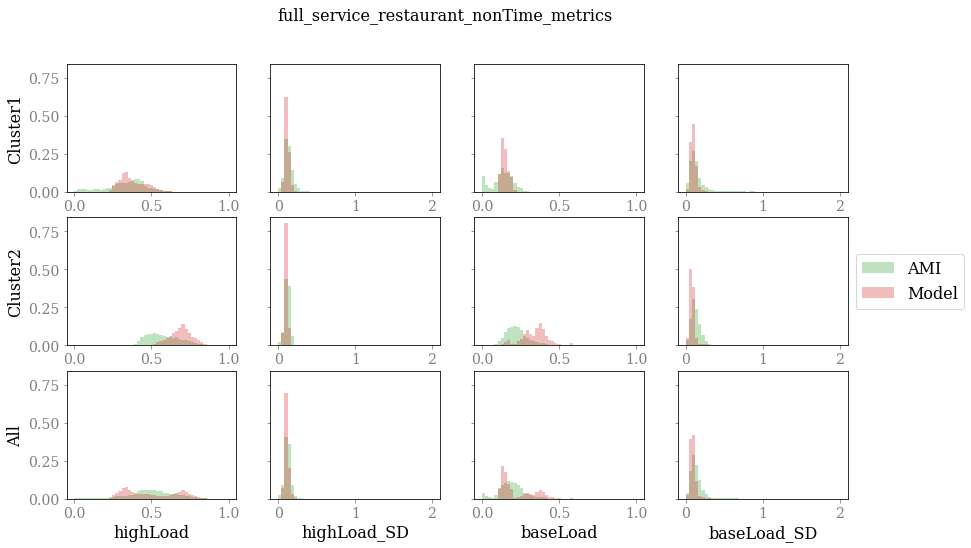

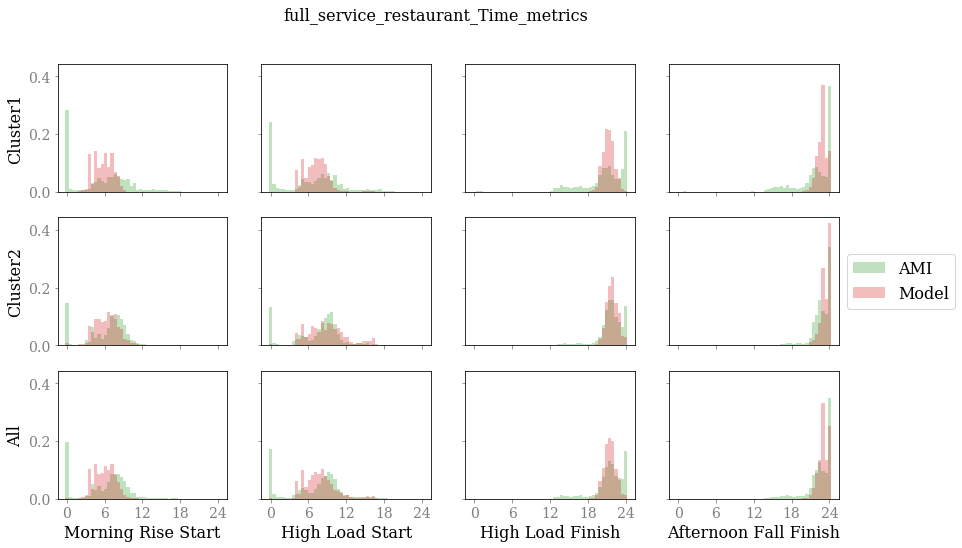

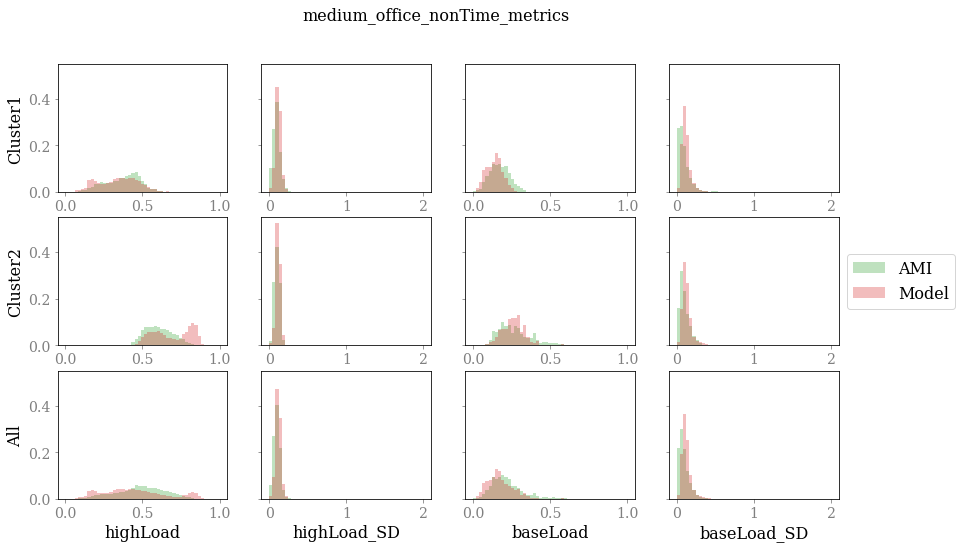

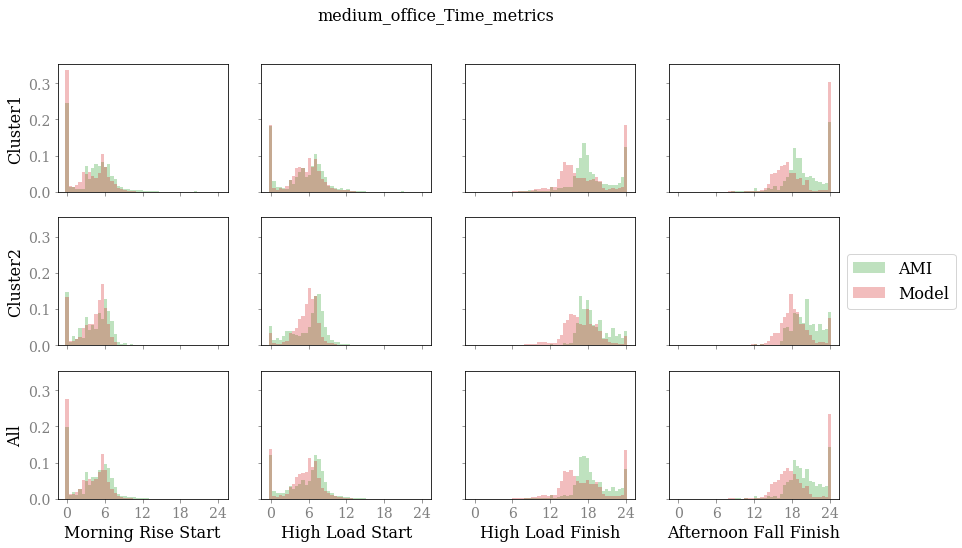

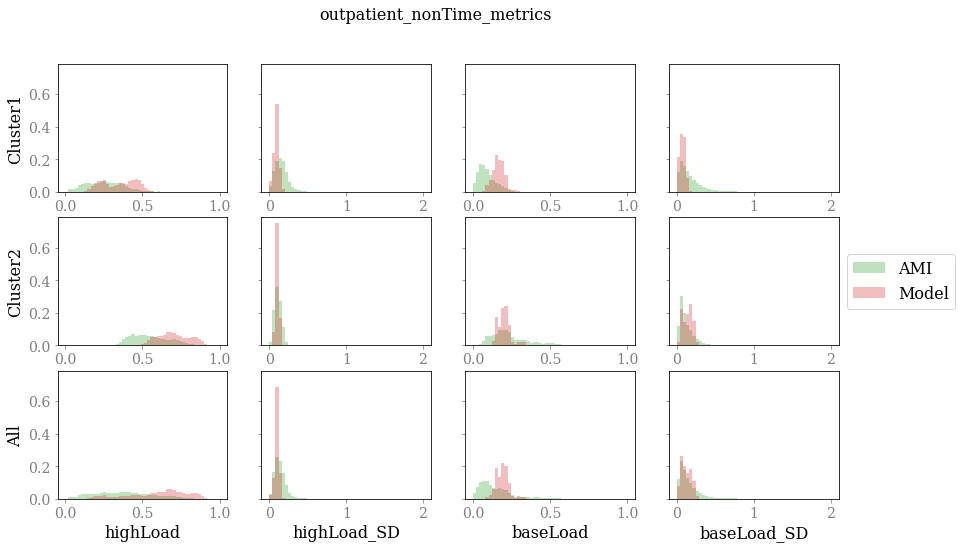

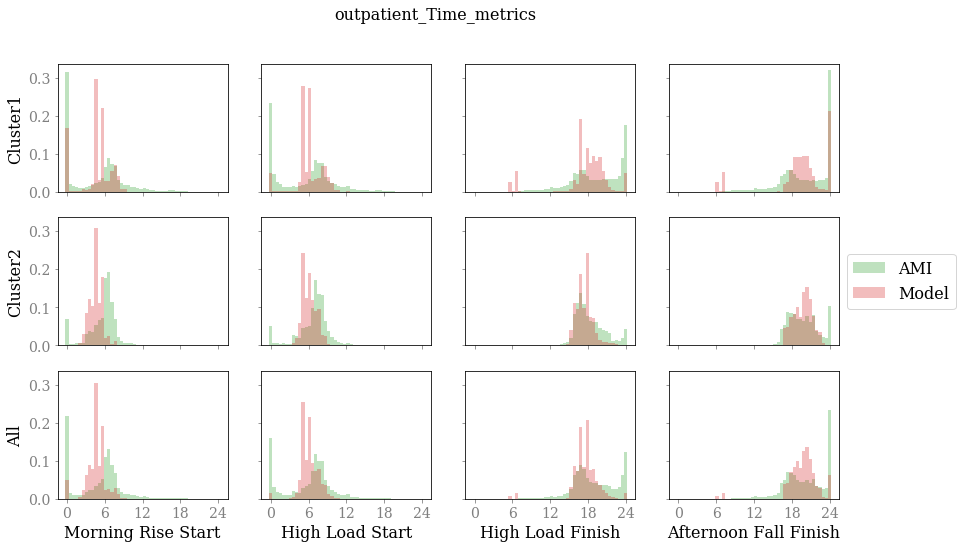

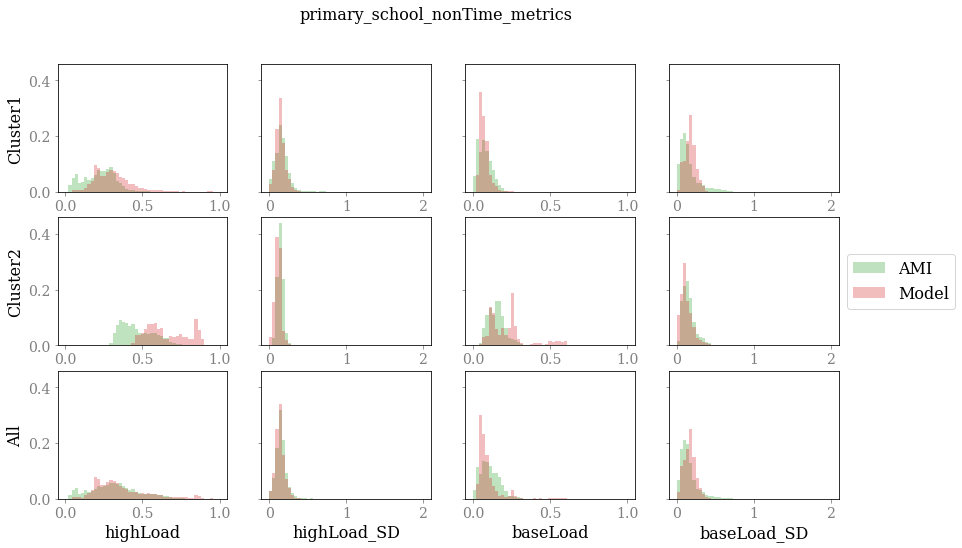

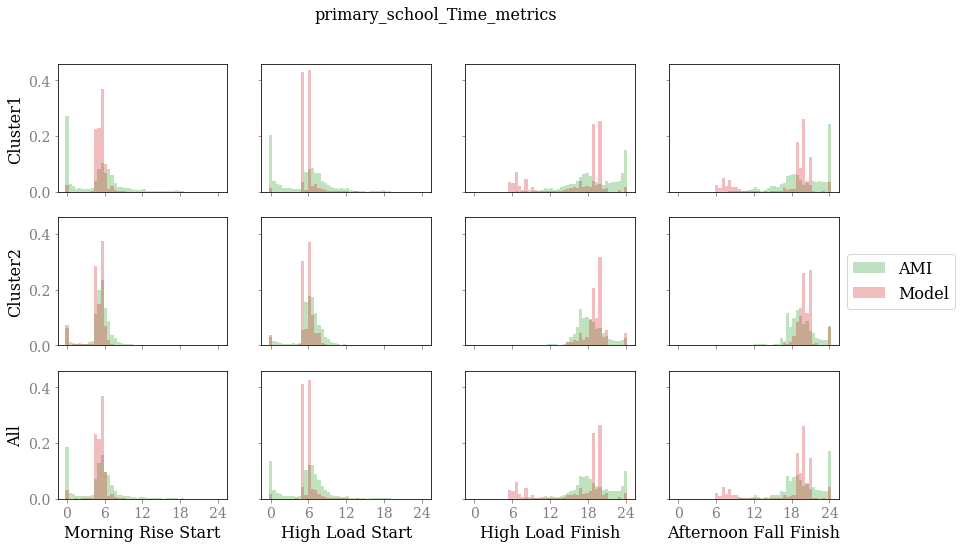

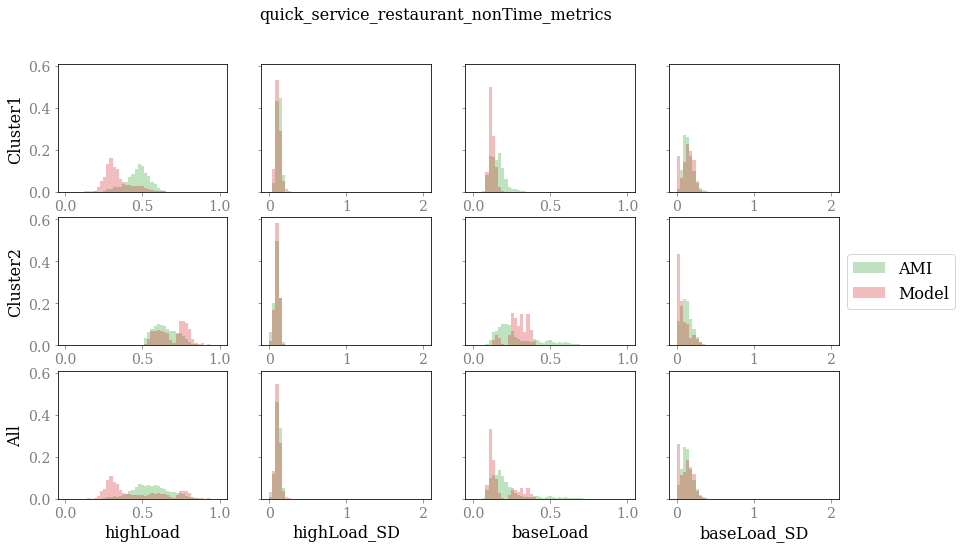

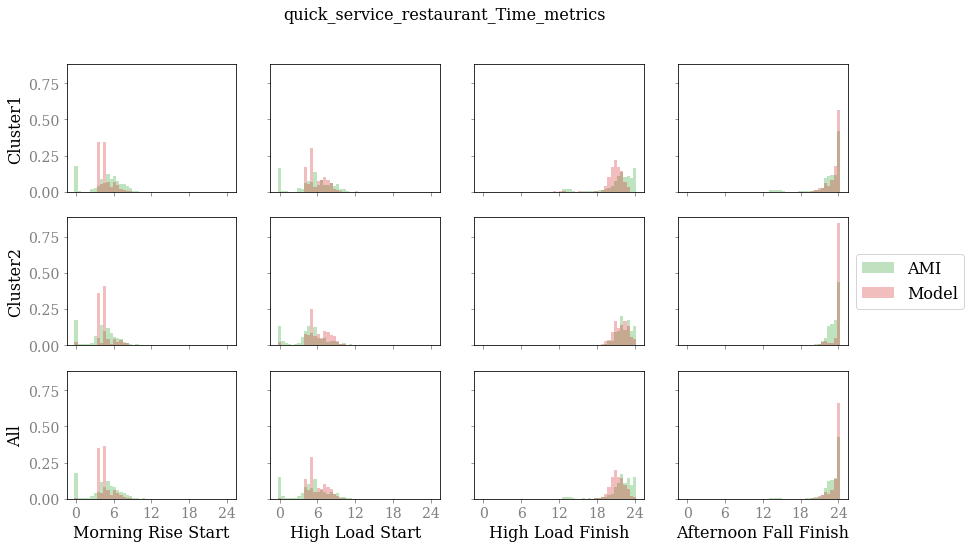

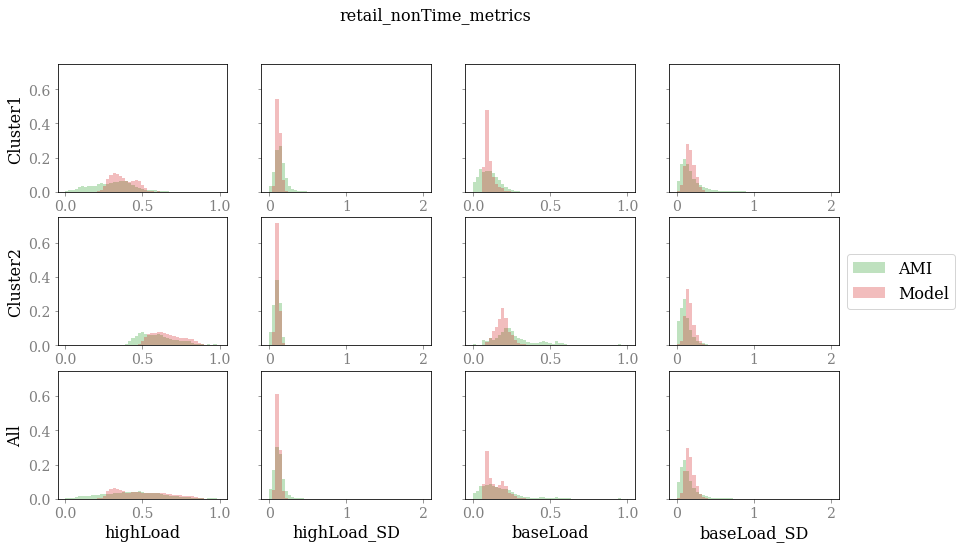

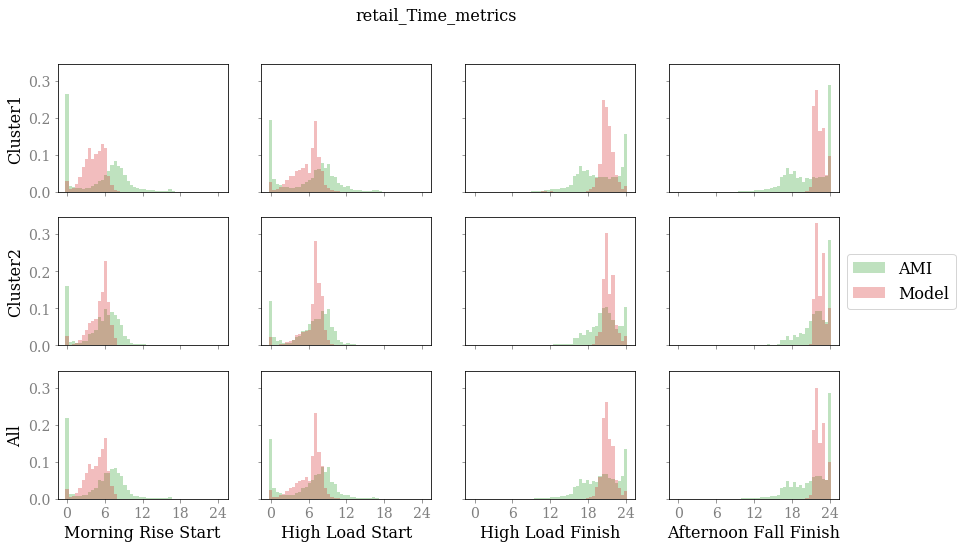

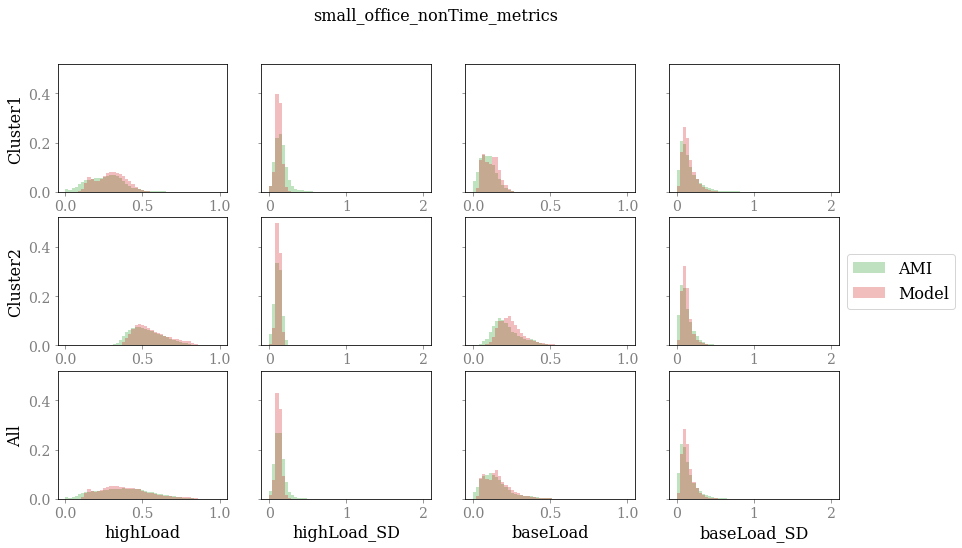

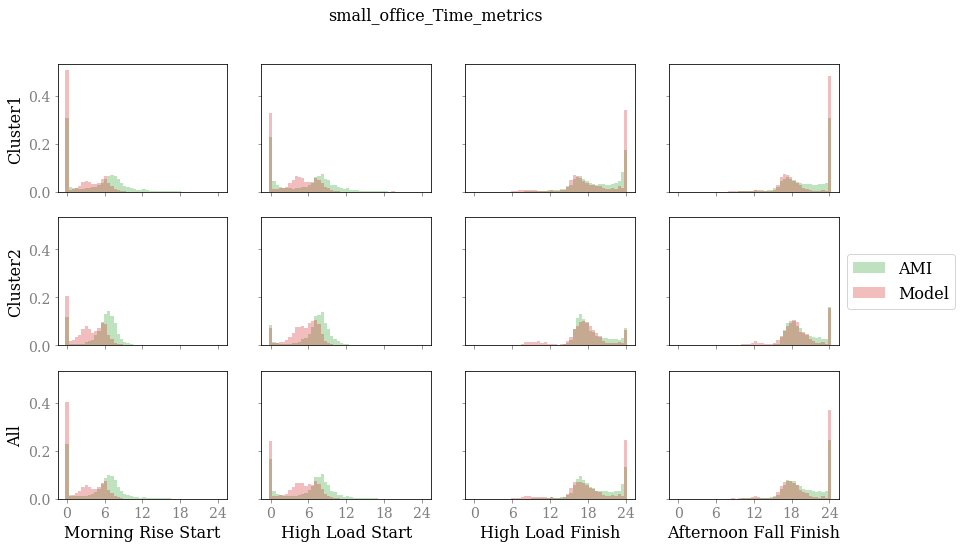

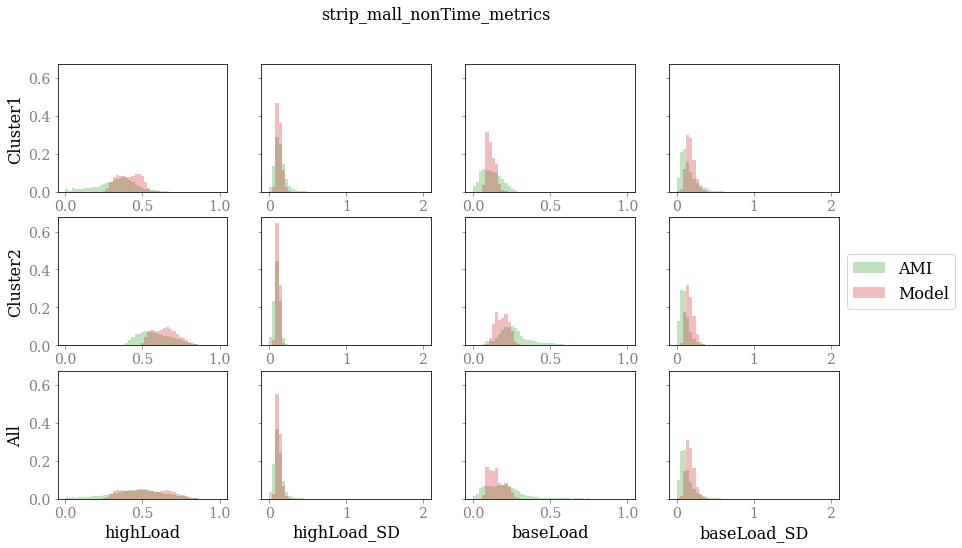

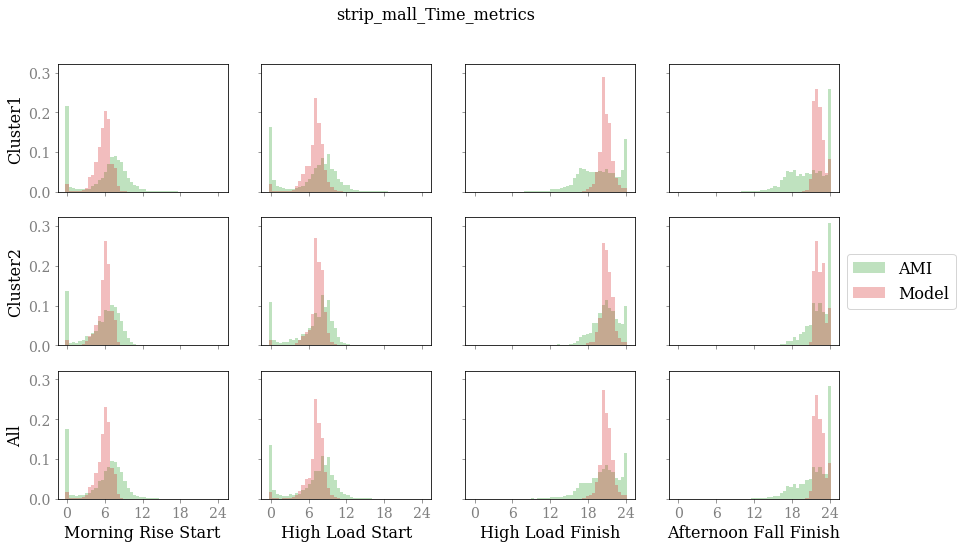

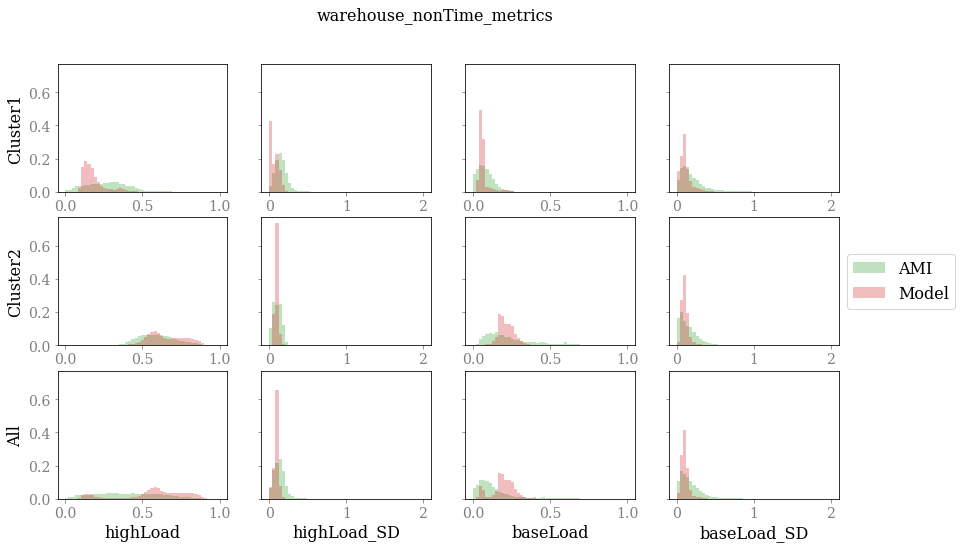

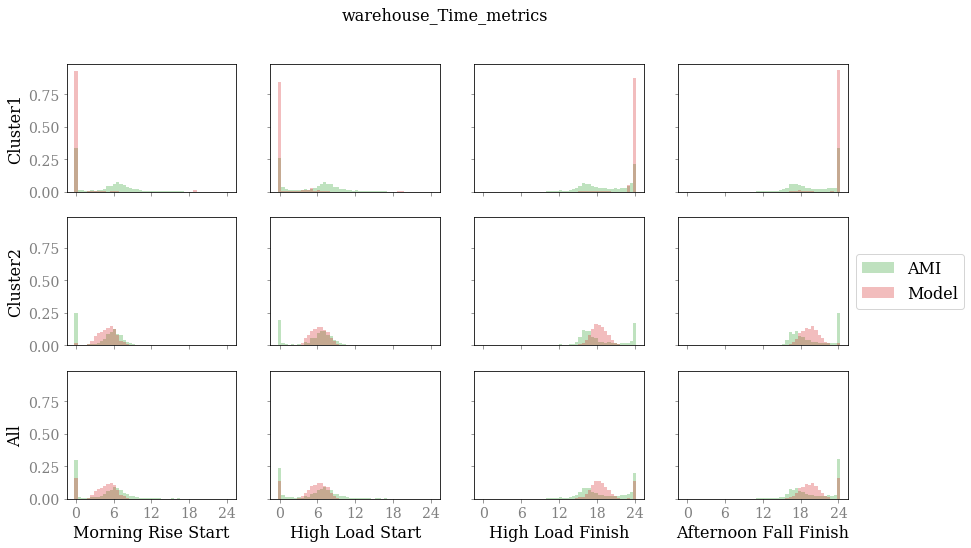

In [18]:
dist = []
'''layers: 
building type
    metrics (i_col)
        cluster (i_row)
'''

for building_type in buildingTypes:
    ## read and combine the data
    ami_all = read_data('ami', building_type, 'statistics')
    model_all = read_data('model', building_type, 'statistics')
    ami_cluster_result = read_data('ami', building_type, 'cluster_result')
    model_cluster_result = read_data('model', building_type, 'cluster_result')

    ami_all = pd.concat([ami_all, ami_cluster_result[['2_clusters']]], axis=1)
    model_all = pd.concat([model_all, model_cluster_result[['2_clusters']]], axis=1)
    
    ## plot highLoad, highLoad_SD, baseLoad and baseLoad_SD
    fig, axs = plt.subplots(3, 4, sharey=True, figsize=(14,8))
    for i_col in range(4):
        metric = column_index[i_col]
        row_data = {0: [ami_all[ami_all['2_clusters']==0][metric].values, model_all[model_all['2_clusters']==0][metric].values],
                    1: [ami_all[ami_all['2_clusters']==1][metric].values, model_all[model_all['2_clusters']==1][metric].values],
                    2: [ami_all[metric].values, model_all[metric].values]}
        bins, time_stick = bins_all[metric]
        for i_row in range(3):
            ami_data, model_data = row_data[i_row]
            axs[i_row,i_col].hist(ami_data, weights=np.ones(ami_data.shape[0])/ami_data.shape[0],
                                  bins=bins, alpha=0.3, label='AMI', color=default_colors[2])
            axs[i_row,i_col].hist(model_data, weights=np.ones(model_data.shape[0])/model_data.shape[0],
                                  bins=bins, alpha=0.3, label='Model', color=default_colors[3])
            kl, corr, mi = cal_dist(ami_data, model_data, bins)  
            dist.append([building_type, metric, i_row, kl, corr, mi])
        axs[2,i_col].set_xlabel(metric)
    axs[1,3].legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.suptitle(f'{building_type}_nonTime_metrics', fontsize=16)
    axs[0,0].set_ylabel('Cluster1')
    axs[1,0].set_ylabel('Cluster2')
    axs[2,0].set_ylabel('All')    
    plt.savefig(os.path.join('fig','validation','byCluster',f'{building_type}_nonTime'))
    
    ## start, finish time
    fig, axs = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(14,8))
    for i_col in range(4):
        metric = column_index[i_col+4]
        row_data = {0: [ami_all[ami_all['2_clusters']==0][metric].values, model_all[model_all['2_clusters']==0][metric].values],
                     1: [ami_all[ami_all['2_clusters']==1][metric].values, model_all[model_all['2_clusters']==1][metric].values],
                     2: [ami_all[metric].values, model_all[metric].values]}
        bins, time_stick = bins_all[metric]
        for i_row in range(3):
            ami_data, model_data = row_data[i_row]
            axs[i_row,i_col].hist(ami_data, weights=np.ones(ami_data.shape[0])/ami_data.shape[0],
                                  bins=bins, alpha=0.3, label='AMI', color=default_colors[2])
            axs[i_row,i_col].hist(model_data, weights=np.ones(model_data.shape[0])/model_data.shape[0],
                                  bins=bins, alpha=0.3, label='Model', color=default_colors[3])
            kl, corr, mi = cal_dist(ami_data, model_data, bins)  
            dist.append([building_type, metric, i_row, kl, corr, mi])

        # xticks and label
        axs[2,i_col].set_xlabel(metric)
        axs[2,i_col].set_xticks(xticks_x)
        axs[2,i_col].set_xticklabels(xticks_label)

    axs[1,3].legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.suptitle(f'{building_type}_Time_metrics', fontsize=16)
    axs[0,0].set_ylabel('Cluster1')
    axs[1,0].set_ylabel('Cluster2')
    axs[2,0].set_ylabel('All')   
    plt.savefig(os.path.join('fig','validation','byCluster',f'{building_type}_Time'))    

## Different distance measures

In [19]:
dist_df = pd.DataFrame(dist, columns=['Building Type', 'Metric', 'cluster', 'KL', 'Corr', 'MI'])
dist_df['Cluster'] = dist_df['cluster'].replace(0,'cluster1').replace(1,'cluster2').replace(2,'all')

dist_df.head()

,Building Type,Metric,cluster,KL,Corr,MI,Cluster
0,full_service_restaurant,highLoad,0,2.861553,0.830261,0.644231,cluster1
1,full_service_restaurant,highLoad,1,5.337544,0.408201,0.425886,cluster2
2,full_service_restaurant,highLoad,2,1.267354,0.519492,0.814388,all
3,full_service_restaurant,highLoad_SD,0,0.696167,0.912475,0.137424,cluster1
4,full_service_restaurant,highLoad_SD,1,0.703502,0.826692,0.115794,cluster2


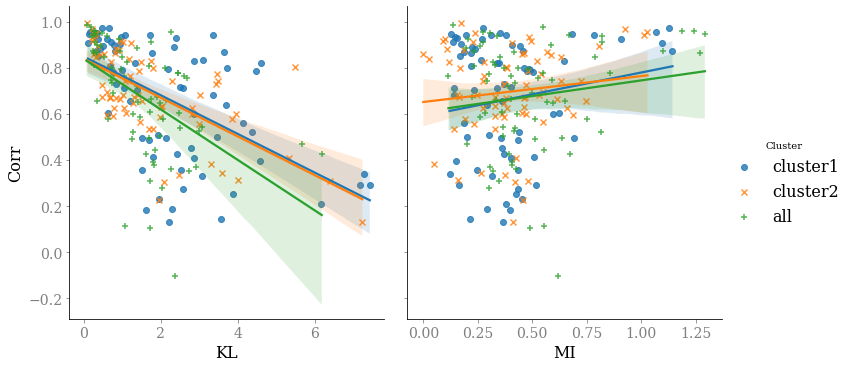

In [20]:
sns.pairplot(dist_df, x_vars=["KL", "MI"], y_vars=["Corr"],
             hue="Cluster", markers=["o", "x", "+"], height=5, kind="reg")
plt.savefig(os.path.join('fig','validation','byCluster',f'dist_measure'))

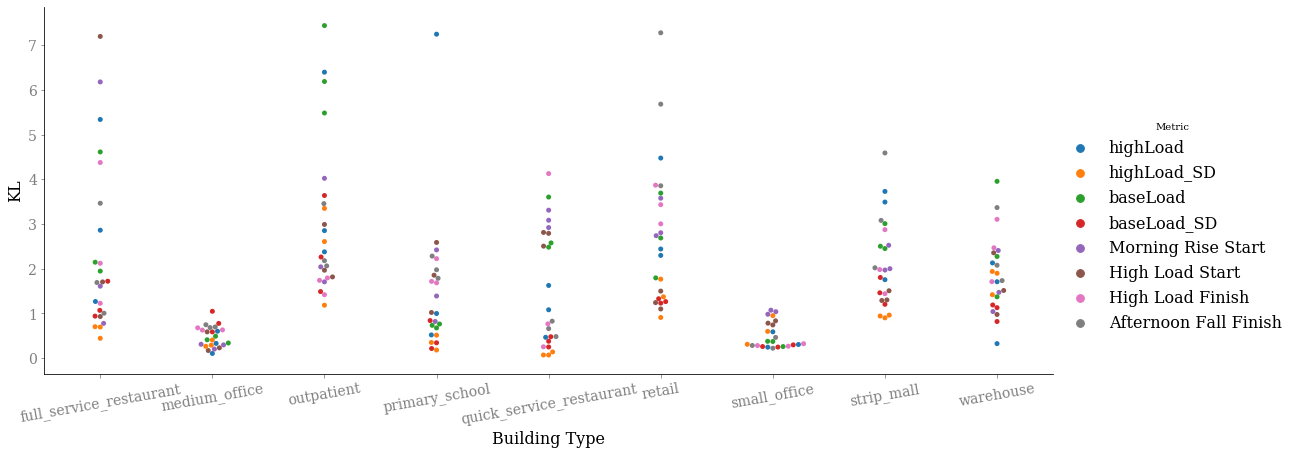

In [21]:
figsize = (15, 6)
sns.catplot(x="Building Type", y="KL", hue="Metric", kind="swarm", data=dist_df, 
            height=figsize[1], aspect=figsize[0]/figsize[1])
plt.xticks(rotation=10)
plt.savefig(os.path.join('fig','validation','byCluster',f'kl_buildingType_measure'))

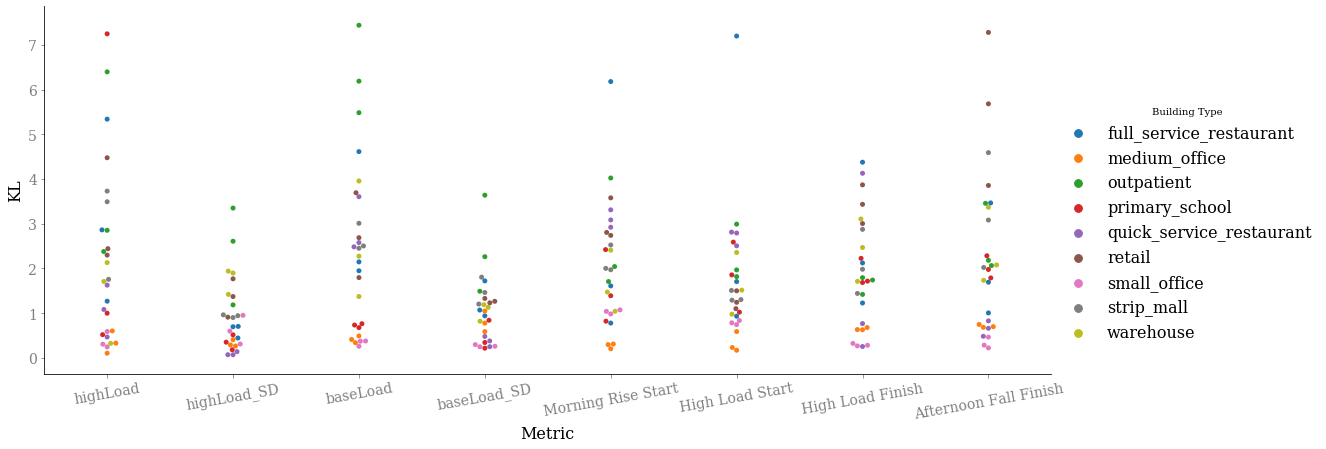

In [22]:
figsize = (15, 6)
sns.catplot(x="Metric", y="KL", hue="Building Type", kind="swarm", data=dist_df, 
            height=figsize[1], aspect=figsize[0]/figsize[1])
plt.xticks(rotation=10)
plt.savefig(os.path.join('fig','validation','byCluster',f'kl_measure_buildingType'))

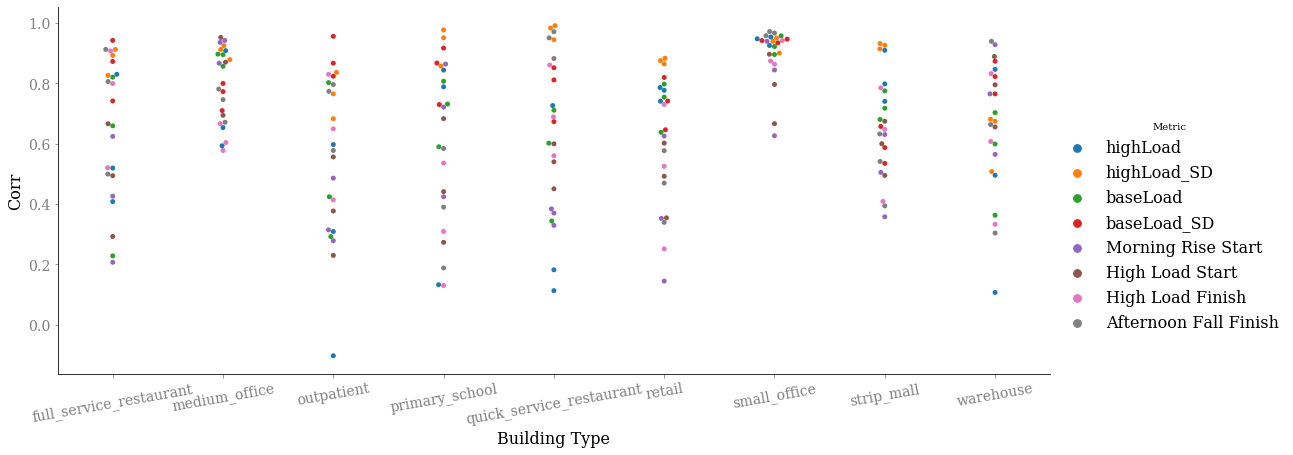

In [23]:
figsize = (15, 6)
sns.catplot(x="Building Type", y="Corr", hue="Metric", kind="swarm", data=dist_df, 
            height=figsize[1], aspect=figsize[0]/figsize[1])
plt.xticks(rotation=10)
plt.savefig(os.path.join('fig','validation','byCluster',f'corr_buildingType_measure'))

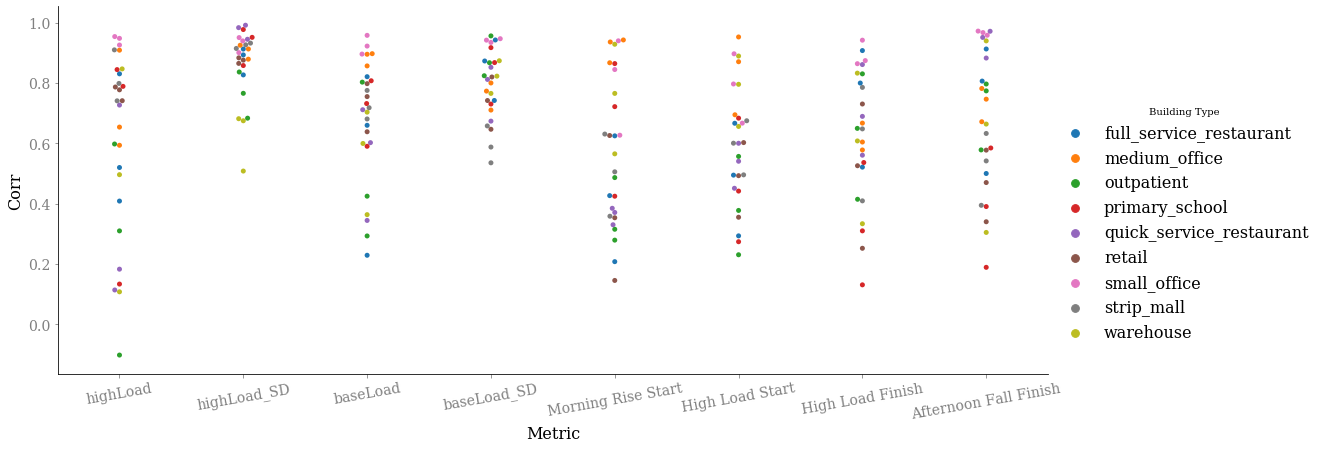

In [24]:
figsize = (15, 6)
sns.catplot(x="Metric", y="Corr", hue="Building Type", kind="swarm", data=dist_df, 
            height=figsize[1], aspect=figsize[0]/figsize[1])
plt.xticks(rotation=10)
plt.savefig(os.path.join('fig','validation','byCluster',f'corr_measure_buildingType'))